## 1. 导入所需的库

In [1]:
# 数据处理
import pandas as pd
import numpy as np
# 文件管理
import os
# 可视化
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from datetime import datetime, timedelta

# 统计分析
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, AutoARIMA, AutoETS
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
pd.set_option('display.width', None)  # 自动调整宽度
pd.set_option('display.max_colwidth', None)  # 显示完整列内容

## 2. 读取数据

In [3]:
path = 'data/round_1/Lok Ma Chau Spur Line.xlsx'
lmc_data = pd.read_excel(path, parse_dates=['Date'], date_format='%d-%m-%Y')
# 读取数据并将日期列转换为datetime格式

In [4]:
# 检查数据
lmc_data.head()

,Date,Total
0,2023-01-08,5680
1,2023-01-09,6455
2,2023-01-10,7910
3,2023-01-11,8594
4,2023-01-12,10113


In [5]:
lmc_data.tail()

,Date,Total
817,2025-04-04,117911
818,2025-04-05,94163
819,2025-04-06,100778
820,2025-04-07,71906
821,2025-04-08,68143


In [6]:
lmc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    822 non-null    datetime64[ns]
 1   Total   822 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.0 KB


In [7]:
lmc_data.describe(include='int64')

,Total
count,822.000000
mean,66494.143552
std,21459.224701
min,5433.000000
25%,55971.000000
50%,63995.000000
75%,77362.750000
max,130819.000000


综合以上检查的步骤，有以下有意义的结论：
1. 数据无缺失，至少没有显而易见的缺失（天数正常）
2. 日期格式成功转化为`datetime`格式
3. 数据无明显异常，如零值、空值等

## 3. 探索分析

In [8]:
plt.rcParams['font.family'] = ['Microsoft YaHei']

In [9]:
os.makedirs('figures', exist_ok=True)
# 创建文件夹用于保存图片

### 3.1  游客总数随时间变化折线图

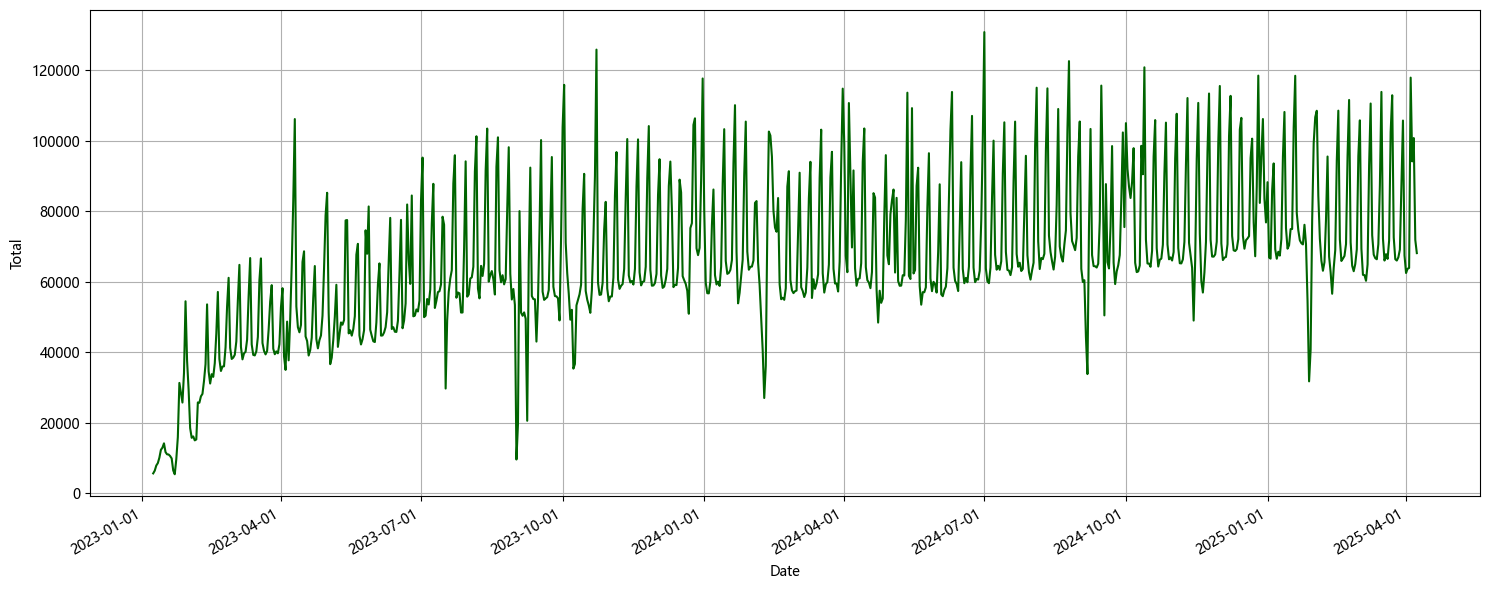

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(lmc_data['Date'], lmc_data['Total'] ,color='darkgreen')
ax.set_xlabel('Date')
ax.set_ylabel('Total')

ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动选择稀疏间隔
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 显示到日

plt.grid(True)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/lmc_total_visitors.png', dpi=300)

仅从上图来看，能看出可能有一定的周期性，通过观察以及联系常识和直觉，周期长度很可能是一周的长度：7天，具体地求解和验证在下一部分进行。

在标注了节假日的图形中，并没有发现特别显著的规律，可能的原因有：
- 节假日对罗湖口岸通关游客人数的影响本就不大，换言之，口岸通关游客人数对节假日不敏感，推断周末的作用才比较强，因为就近的游客来往便利且人数占比较高
- 两年内的节假日数量太少，不足以反映出节假日对游客人数的影响和不同节日之间的差异
- 存在其他因素的干扰，如政策调整、天气变化、交通拥堵等

### 3.2 季节分解




由于察觉到数据的周期性，考虑采用自相关图和偏自相关图来确定数据的滞后阶数，即周期长度，后者可以去除中间滞后项的影响

本次使用的数据显然有着系统性上升的趋势，是一个典型的非平稳序列，因此需要进行差分处理

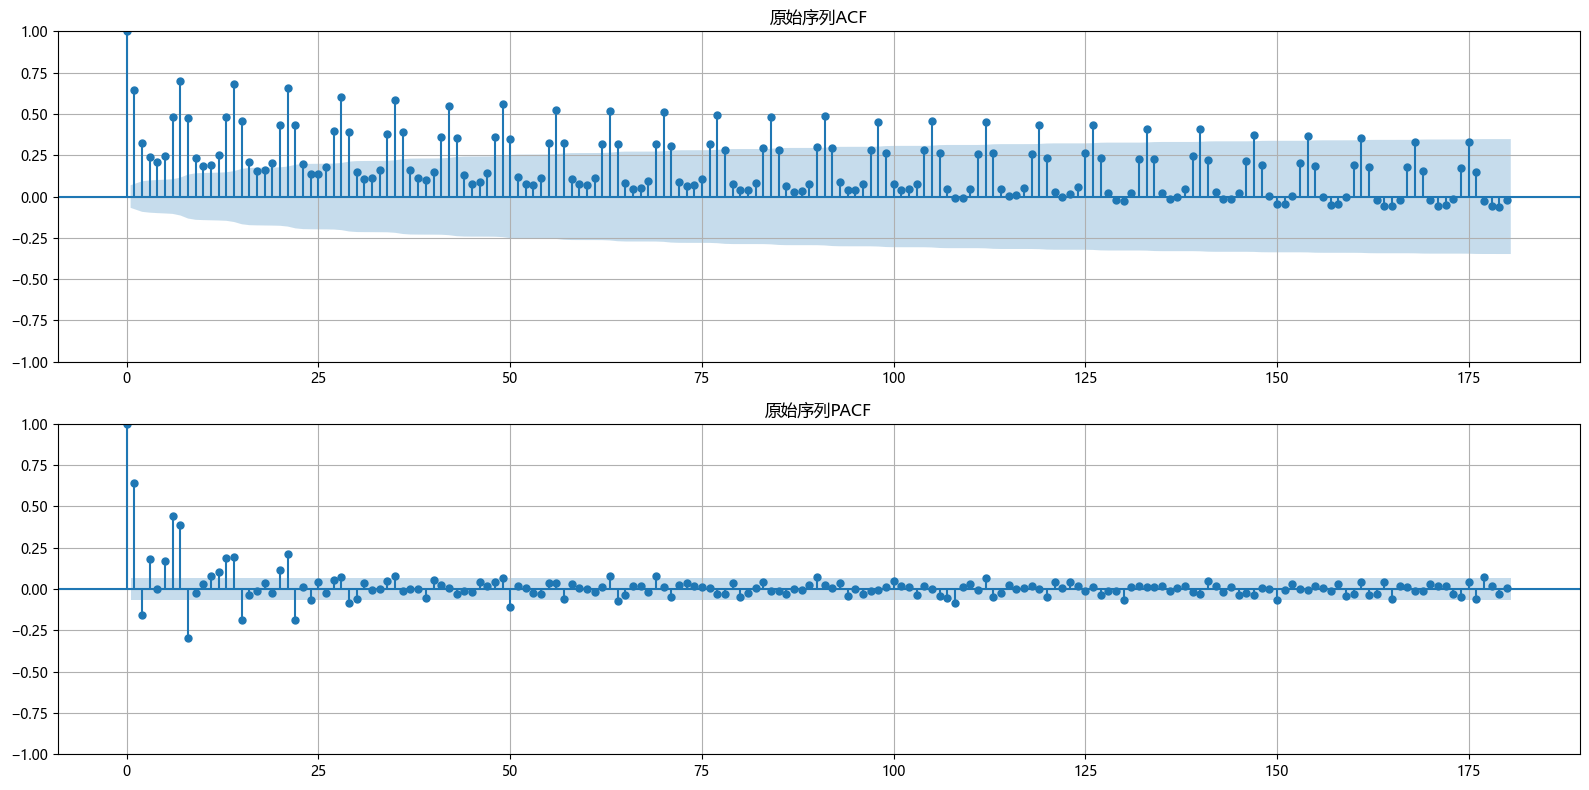

In [11]:
# 原始序列ACF
fig, ax = plt.subplots(2,1, figsize=(16,8))
plot_acf(lmc_data['Total'], lags=180, ax=ax[0])
ax[0].set_title('原始序列ACF')
ax[0].grid(True)
plot_pacf(lmc_data['Total'], lags=180, ax=ax[1], method='ywm')
ax[1].set_title('原始序列PACF')
ax[1].grid(True)

plt.tight_layout()

plt.savefig('figures/lmc_ACF_PACF.png', dpi=300)

> 浅蓝色部分为置信区间，超出置信区间的部分为显著的滞后阶数及其相关系数

可以看到：
- ACF结果中，第一个显著的滞后阶数是1，其后在滞后阶数为7的倍数时有显著峰，整体呈现**缓慢衰减**的形态，值得注意的是在峰的两侧也有较高自相关值，这是上述的系统性上升趋势所致
- PACF结果中，同样地，第一个显著的滞后阶数是1，整体呈现**快速衰减**的形态，因为趋势导致相邻值直接相关

非平稳的数据使得自相关分析失效，因此，考虑使用一阶差分来去除趋势，再进行自相关图和偏自相关图的绘制

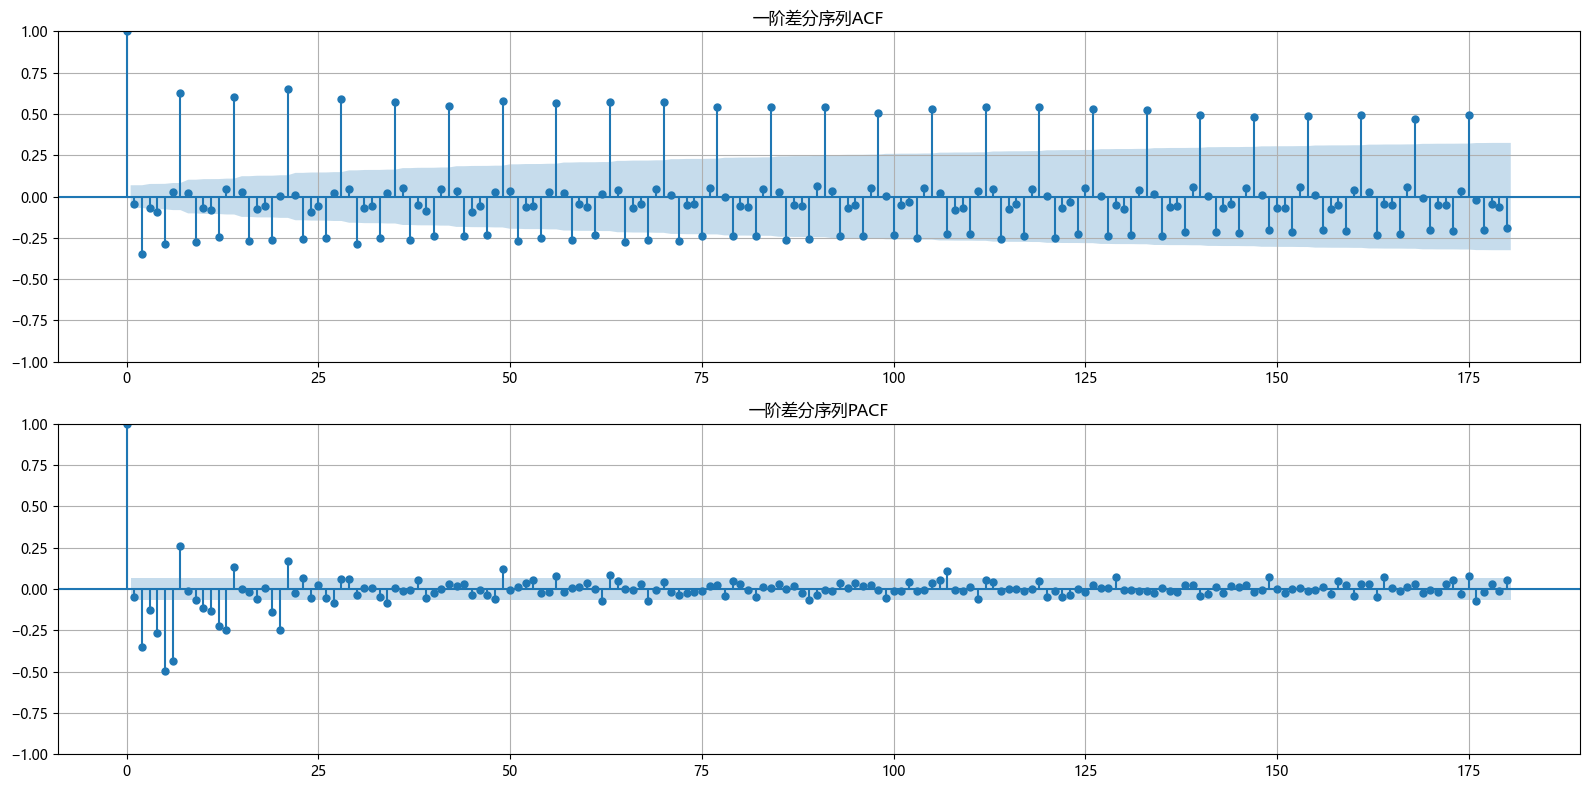

In [12]:
# 差分后序列ACF（示例）
fig, ax = plt.subplots(2,1, figsize=(16,8))
plot_acf(lmc_data['Total'].diff().dropna(), lags=180, ax=ax[0])
ax[0].set_title('一阶差分序列ACF')
ax[0].grid(True)
plot_pacf(lmc_data['Total'].diff().dropna(), lags=180, ax=ax[1], method='ywm')
ax[1].set_title('一阶差分序列PACF')
ax[1].grid(True)

plt.tight_layout()
plt.savefig('figures/lmc_ACF_PACF_diff.png', dpi=300)

经过差分处理后的图形展示了：
- ACF结果中，第一个显著的滞后阶数是7，其后在以7为周期出现显著峰，整体呈现**缓慢衰减**的形态
- PACF结果中，第一个显著的滞后阶数是7，整体呈现**快速衰减**的形态

综合两图的结果，有结论如下：
- 周期长度确认为7
- 一阶差分后，自相关图呈现**缓慢衰减**的形态，偏自相关图呈现**快速衰减**的形态，该结果对后续模型的参数调整有参考作用

In [13]:
# 还可以通过季节分解的结果验证季节性的存在
stl = STL(lmc_data['Total'], period=7).fit()
seasonal_strength = 1 - np.var(stl.resid)/np.var(stl.seasonal+stl.resid)
print(seasonal_strength)
if seasonal_strength > 0.64:
    print("强季节性存在")

0.7934945047478533
强季节性存在


In [14]:
trend = stl.trend
seasonal = stl.seasonal
resid = stl.resid

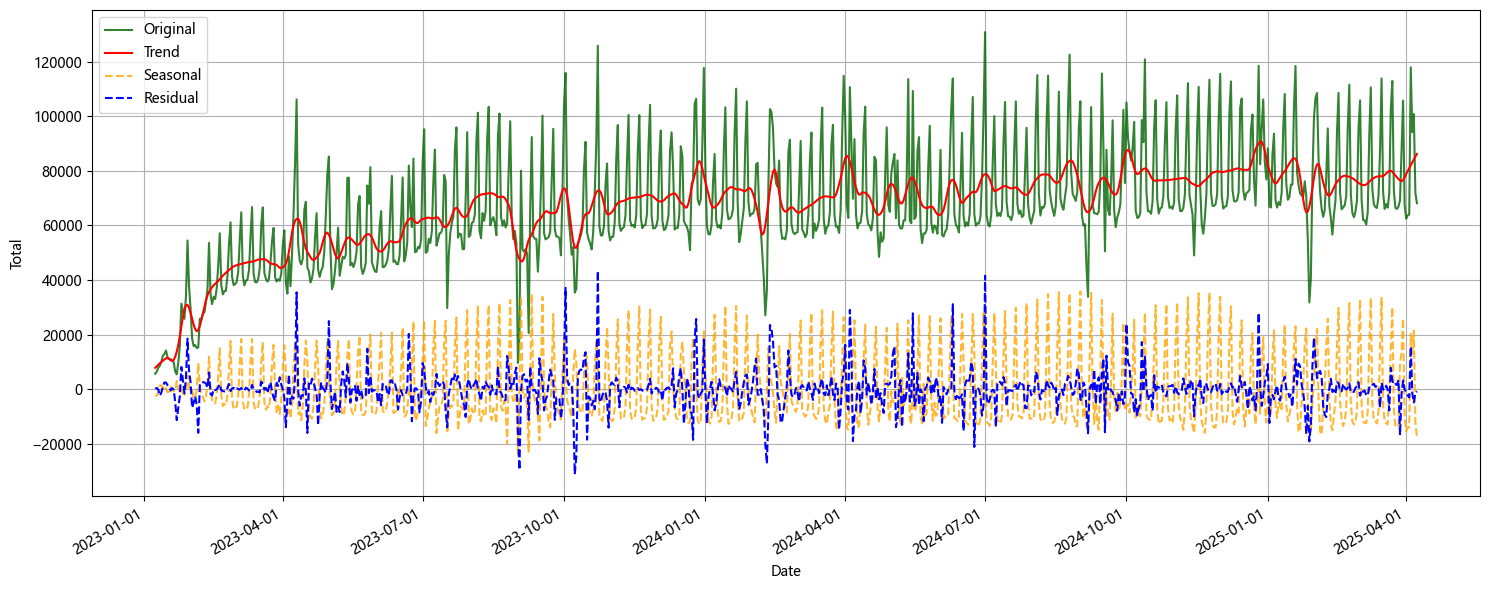

In [15]:
fig,ax = plt.subplots(figsize=(15, 6))
ax.plot(lmc_data['Date'], lmc_data['Total'], color='darkgreen', label='Original', alpha=0.8)
ax.plot(lmc_data['Date'],  trend, color='red', label='Trend')
ax.plot(lmc_data['Date'], seasonal, color='orange', linestyle='--', label='Seasonal', alpha=0.8)
ax.plot(lmc_data['Date'], resid, color='blue', linestyle='--', label='Residual')
ax.set_xlabel('Date')
ax.set_ylabel('Total')

ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # 自动选择稀疏间隔
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # 显示到日

plt.legend(loc='best')

plt.grid(True)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/brdge_decompose.png', dpi=300)

由上图，可以看出：
- 趋势整体呈现上升形态，但仍有一定的波动性
- 季节性较强，周期内的规律明显，大致呈现峰值在周末、谷值在周中的情况，符合预期
- 周期的影响也是波动的
- 残差部分有较大的波动，说明趋势和季节性未能完全解释数据的变化，考虑实际情况，重大活动、节庆、政策调整、天气等众多因素都可能影响游客人数

## 5. 预测与评估

预测的目标是最后20个数据点

### 5.1 划分训练集和测试集

In [16]:
data = lmc_data.copy()
data.insert(0, 'unique_id', 1)
data.head()

,unique_id,Date,Total
0,1,2023-01-08,5680
1,1,2023-01-09,6455
2,1,2023-01-10,7910
3,1,2023-01-11,8594
4,1,2023-01-12,10113


In [17]:
# 划分训练集和测试集
train = data[:-20]
test = data[-20:]

In [18]:
test.head()

,unique_id,Date,Total
802,1,2025-03-20,66502
803,1,2025-03-21,71688
804,1,2025-03-22,102514
805,1,2025-03-23,112913
806,1,2025-03-24,72611


### 5.2 模型训练与预测

考虑到任务的要求以及代码的简洁性、使用不同模型的需要，这里使用了`StatsForecast`库中的`Naive`、`ETS`和`SARIMA`模型并引用了`StatsForecast`类进行滚动窗口预测器的定义，并使用`MAPE`作为评估指标。
> 可以通过更改模型参数、指定步长列表来扩展预测器的功能

In [19]:
# 设置模型参数
configs = [
    {
        'name': 'Naive',         # 模型显示名称
        'class': Naive,          # 模型类
        'params': {}             # 模型初始化参数
    },
    {
        'name': 'ETS',
        'class': AutoETS,
        'params': {
            'season_length': 7
        }
    },
    {
        'name': 'SARIMA',
        'class': AutoARIMA,
        'params': {
            'season_length':7
        }
    }
]

In [20]:
# 定义滚动窗口预测器
class RollingForecaster:
    def __init__(self, train_df, test_df,steps = [1,2,3], model_configs=configs):
        self.train = train_df # 训练集
        self.test = test_df # 测试集
        self.steps = steps # 预测步长
        self.model_configs = model_configs # 模型配置

        # 动态创建模型实例
        self.models = [
            cfg['class'](**cfg['params'])  # 解包参数实例化
            for cfg in model_configs # 遍历模型配置
        ]
        self.model_names = [cfg['name'] for cfg in model_configs] # 模型名称

    def rolling_forecast(self, model, horizon):
        current_train = self.train # 定义当前训练集
        current_test = self.test
        predictions= [] # 定义预测结果
        # 循环预测
        for i in range(0, len(self.test), horizon):
            fcst = StatsForecast(
                models=[model],
                freq='D', # 时间频率(日)
            )
            forecast = fcst.forecast(
                df = current_train,
                h=horizon,
                time_col='Date',
                target_col='Total'
            )
            # 记录结果
            used_test = current_test[:horizon]
            pred = forecast[model.__class__.__name__].values[:len(used_test)]
            predictions.extend(pred)
            # 更新训练集和测试集
            current_train = pd.concat([current_train[horizon:], used_test])
            current_test = current_test[len(used_test):]
        return predictions

    def run(self):
        metrics = pd.DataFrame(index = self.steps, columns=self.model_names.append('Ensemble'))
        df_predictions = self.test.copy()
        for h in self.steps:
            for model, name in zip(self.models, self.model_names):
                 results = self.rolling_forecast(model, h)
                 df_predictions[f'{name}_{h}'] = results
                 metrics.loc[h, name] = mape(self.test['Total'], results)
            df_predictions[f'Ensemble_{h}'] = df_predictions.iloc[:, -len(self.model_names)+1:].mean(axis=1)
            metrics.loc[h, 'Ensemble'] = mape(self.test['Total'], df_predictions[f'Ensemble_{h}'])

        # 输出结果
        return metrics, df_predictions

In [21]:
forecaster = RollingForecaster(train, test)
metrics, df_predictions = forecaster.run()

### 5.3 结果评估

In [22]:
metrics

,Naive,ETS,SARIMA,Ensemble
1,0.173418,0.073969,0.062766,0.095357
2,0.232895,0.085740,0.073734,0.124546
3,0.215897,0.066645,0.059669,0.104099


#### 5.3.1 绘制柱状图以更直观地展示预测效果评价

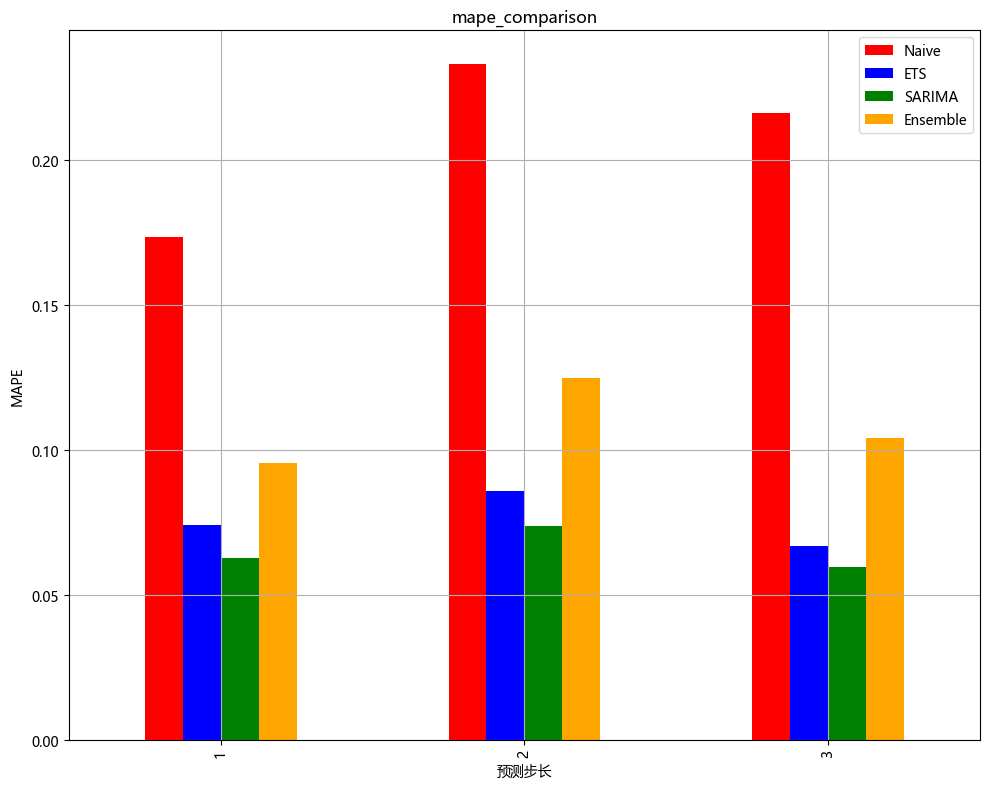

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

metrics.plot(kind='bar', ax=ax, color=['red', 'blue', 'green', 'orange'])
ax.set_xlabel('预测步长')
ax.set_ylabel('MAPE')
ax.set_title('mape_comparison')

plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.savefig('figures/lmc_mape_comparision.png', dpi=300)

#### 5.3.2 绘制折线图在时间轴上展示预测结果

In [24]:
def plot_step_predictions(ax, step, df):
    ax.set_title(f'Step {step}')
    ax.plot(df['Date'], df[f'Naive_{step}'], color='red', label='Naive', linewidth=2, alpha=0.7)
    ax.plot(df['Date'], df[f'ETS_{step}'], color='blue', label='ETS', linewidth=2, alpha=0.7)
    ax.plot(df['Date'], df[f'SARIMA_{step}'], color='green', label='SARIMA', linewidth=2, alpha=0.7)
    ax.plot(df['Date'], df[f'Ensemble_{step}'], color='orange', label='Ensemble', linewidth=2)
    ax.legend(loc='best')

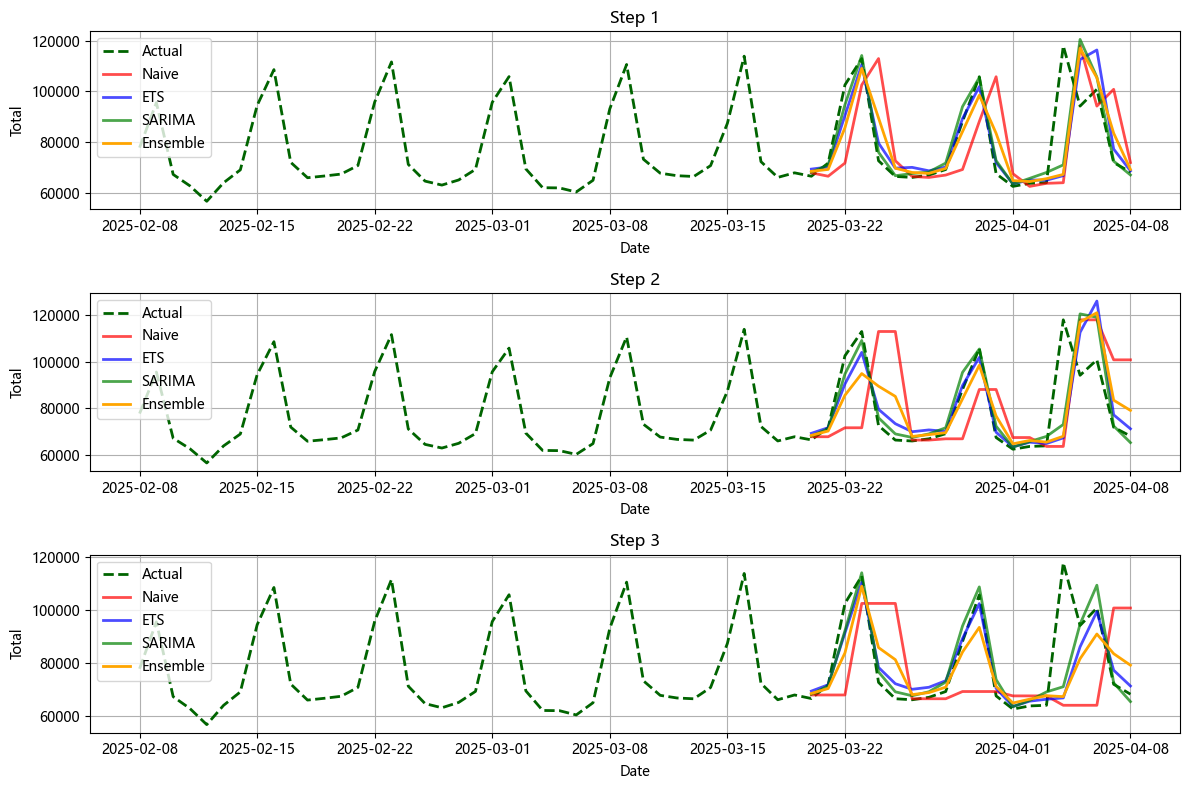

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
# 绘制预测结果
for i, ax in enumerate([ax1, ax2, ax3], start=1):
    ax.plot(lmc_data['Date'][-60:] ,lmc_data['Total'][-60:], color = 'darkgreen' ,label='Actual', linewidth=2, linestyle='--')
    plot_step_predictions(ax, i, df_predictions)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动选择稀疏间隔
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 显示到日
    ax.grid(True)

plt.tight_layout()
plt.savefig('figures/lmc_predictions.png', dpi=300)

综上，可以看出：
- `Naive`模型的预测效果明显比其他模型差，这符合我们的预期，因为其预测使用的信息最少
- 其他模型由差到优依次是：`ETS`,`SARIMA`,`Ensemble`，`Ensemble`模型的预测效果最好因为综合考虑了所有模型的预测结果，预测比较稳健，即便本实验中的组合只是简单的平均，也能取得较好的效果
- 所有模型的`mape`都呈现出在预测步长为1和3时较低，而在预测步长为2时较高的情况，这可能是由于数据的周期性，即步长为2时预测目标处在周期过渡的位置，导致预测效果不佳

## 6. 改变模型参数（添加新模型）和预测步长

先前定义的预测器很容易添加新模型和改变预测步长，我们可以尝试看看添加新模型和改变预测步长后的效果

In [26]:
from statsforecast.models import AutoTBATS, DynamicOptimizedTheta, MSTL

**说明**：
1. `AutoTBATS`
`AutoTBATS`是一种自动的时间序列分解方法，能够自动选择合适的参数，以适应不同的时间序列特征，并且支持加法和乘法模型，适用于具有季节性和趋势性的时间序列。
2. `DynamicOptimizedTheta`
`Theta`方法在M3竞赛中击败传统统计模型，此版本通过动态优化实现趋势-季节分解的自动化，对非平稳序列预测准确率高。
3. `MSTL`
现代改进版STL分解+残差预测框架，通过多重季节性分解剥离复杂周期成分，残差可用任意模型预测，灵活性强且解释性极佳。

In [27]:
# 设置模型参数
add_configs = [
    {
        'name': 'Naive',         # 模型显示名称
        'class': Naive,          # 模型类
        'params': {}             # 模型初始化参数
    },
    {
        'name': 'ETS',
        'class': AutoETS,
        'params': {
            'season_length': 7
        }
    },
    {
        'name': 'SARIMA',
        'class': AutoARIMA,
        'params': {
            'season_length':7
        }
    },
    {
        'name': 'AutoTBATS',
        'class': AutoTBATS,
        'params': {
           'season_length': 7
        }
    },
    {
        'name': 'DynamicOptimizedTheta',
        'class': DynamicOptimizedTheta,
        'params': {
            'season_length': 7
        }
    },
    {
        'name': 'MSTL',
        'class': MSTL,
        'params': {
            'season_length': 7
        }
    }
]

In [28]:
add_forecaster = RollingForecaster(train, test, steps=[1, 3, 5], model_configs=add_configs)
add_metrics, add_df_predictions = add_forecaster.run()

In [29]:
add_metrics

,Naive,ETS,SARIMA,AutoTBATS,DynamicOptimizedTheta,MSTL,Ensemble
1,0.173418,0.073969,0.062766,0.065455,0.079160,0.070036,0.078344
3,0.215897,0.066645,0.059669,0.065205,0.063400,0.061271,0.076244
5,0.216855,0.072435,0.061802,0.067067,0.066205,0.056109,0.080283


In [30]:
add_df_predictions.head()

,unique_id,Date,Total,Naive_1,ETS_1,SARIMA_1,AutoTBATS_1,DynamicOptimizedTheta_1,MSTL_1,Ensemble_1,...,DynamicOptimizedTheta_3,MSTL_3,Ensemble_3,Naive_5,ETS_5,SARIMA_5,AutoTBATS_5,DynamicOptimizedTheta_5,MSTL_5,Ensemble_5
802,1,2025-03-20,66502,67848.0,69313.898438,68136.890625,67295.875000,67123.343750,69833.796875,68258.632812,...,67123.343750,69833.796875,68258.632812,67848.0,69313.898438,68136.890625,67295.875000,67123.343750,69833.796875,68258.632812
803,1,2025-03-21,71688,66502.0,70148.789062,70917.734375,68375.648438,68843.945312,73373.492188,69693.601562,...,69180.367188,74899.828125,70641.757812,67848.0,71712.265625,71311.578125,68898.531250,69180.367188,74899.828125,70641.757812
804,1,2025-03-22,102514,71688.0,90457.679688,94709.609375,90416.781250,90846.906250,93793.015625,88652.000000,...,89300.734375,95706.882812,87390.539062,67848.0,91335.500000,92159.265625,87992.851562,89300.734375,95706.882812,87390.539062
805,1,2025-03-23,112913,102514.0,110437.953125,114119.375000,113233.312500,114470.742188,113701.187500,111412.757812,...,114470.742188,113701.187500,111412.757812,67848.0,104912.304688,106134.195312,102532.406250,105224.484375,110430.140625,99513.585938
806,1,2025-03-24,72611,112913.0,79587.148438,75962.117188,76948.875000,79439.804688,77294.875000,83690.976562,...,80032.242188,78300.195312,82705.664062,67848.0,72492.718750,72371.789062,73023.664062,73590.000000,75074.851562,72400.164062


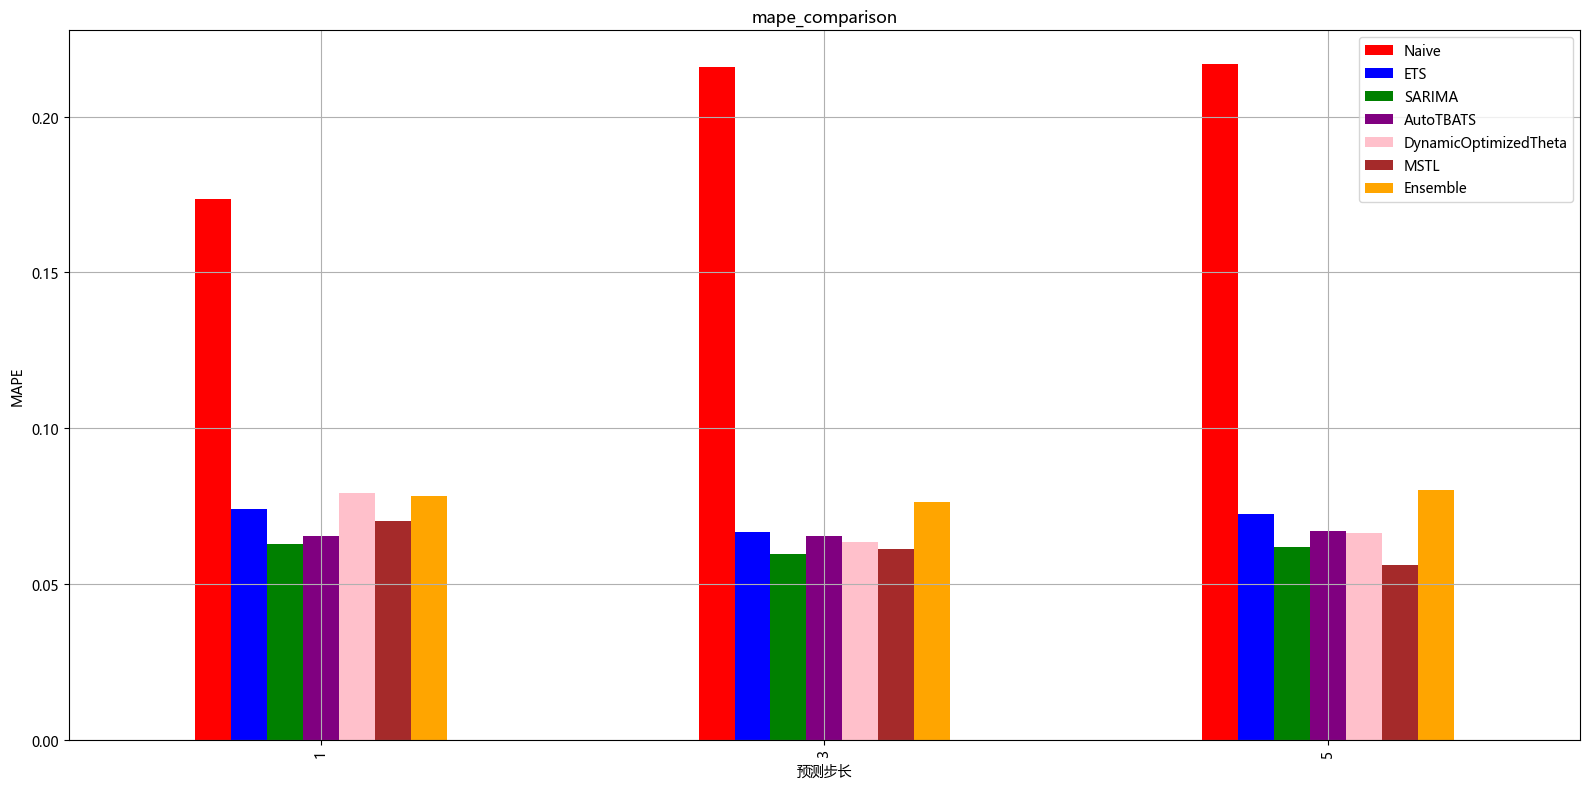

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))

add_metrics.plot(kind='bar', ax=ax, color=['red', 'blue', 'green', 'purple', 'pink', 'brown', 'orange'])
ax.set_xlabel('预测步长')
ax.set_ylabel('MAPE')
ax.set_title('mape_comparison')

plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.savefig('figures/lmc_add_mape_comparision.png', dpi=300)

综上有以下发现：
- `AutoTBATS`模型带来了一些提升，因为其自动选择最优的模型参数，能够处理复杂的季节性和趋势，对异常值和噪声有一定的鲁棒性
- 不同模型受预测步长变化的影响不同，因此在不同的场景或者限制下，选择合适的模型很重要
- 当预测步长很大时，`AutoTBATS`模型的性能可能会下降，因为其对未来的预测能力有限，而`SARIMA`模型的性能可能会上升，因为其能够捕捉到长期的趋势和季节性，各模型性能随步长增大到一定程度后趋于稳定
- 简单组合平均的效果总是不错的，而在预测步长较大时更明显，因为简单组合平均的预测结果更加平滑